In [1]:
import pandas as pd
import numpy as np

In [2]:
plays = pd.read_csv('data_lastfm/user_artists.dat', sep='\t')
artists = pd.read_csv('data_lastfm/artists.dat', sep='\t', usecols=['id','name'])

# Merge artist and user pref data
ap = pd.merge(artists, plays, how="inner", left_on="id", right_on="artistID")
ap = ap.rename(columns={"weight": "playCount"})

# Group artist by name
artist_rank = ap.groupby(['name']) \
    .agg({'userID' : 'count', 'playCount' : 'sum'}) \
    .rename(columns={"userID" : 'totalUsers', "playCount" : "totalPlays"}) \
    .sort_values(['totalPlays'], ascending=False)

artist_rank['avgPlays'] = artist_rank['totalPlays'] / artist_rank['totalUsers']
artist_rank.head(6)

,totalUsers,totalPlays,avgPlays
name,,,
Britney Spears,522,2393140,4584.559387
Depeche Mode,282,1301308,4614.567376
Lady Gaga,611,1291387,2113.563011
Christina Aguilera,407,1058405,2600.503686
Paramore,399,963449,2414.659148
Madonna,429,921198,2147.314685


In [3]:
# Merge into ap matrix
ap = ap.join(artist_rank, on="name", how="inner") \
    .sort_values(['playCount'], ascending=False)

# Preprocessing
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
ap = ap.assign(playCountScaled=play_count_scaled)


# Build a user-artist rating matrix 
ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
ratings = ratings_df.fillna(0).values

# Show sparsity
sparsity = float(len(ratings.nonzero()[0])) / (ratings.shape[0] * ratings.shape[1]) * 100
print("sparsity: %.2f" % sparsity)


sparsity: 0.28


In [4]:
from scipy.sparse import csr_matrix

# Build a sparse matrix
X = csr_matrix(ratings)

n_users, n_items = ratings_df.shape
print("rating matrix shape", ratings_df.shape)

user_ids = ratings_df.index.values
artist_names = ap.sort_values("artistID")["name"].unique()

rating matrix shape (1892, 17632)


In [5]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset

# Build data references + train test
Xcoo = X.tocoo()
data = Dataset()
data.fit(np.arange(n_users), np.arange(n_items))
interactions, weights = data.build_interactions(zip(Xcoo.row, Xcoo.col, Xcoo.data)) 
train, test = random_train_test_split(interactions)

# Ignore that (weight seems to be ignored...)
#train = train_.tocsr()
#test = test_.tocsr()
#train[train==1] = X[train==1]
#test[test==1] = X[test==1]

# To be completed...

In [6]:
# Train
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(train, epochs=10, num_threads=2)


In [7]:
# Evaluate
train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.39, test 0.13.
AUC: train 0.97, test 0.86.


In [8]:
# calculate score model
score = auc_score(model, test_interactions=test, train_interactions=None,
              user_features=None, item_features=None,
              preserve_rows=False, num_threads=1, check_intersections=True).mean()

print(score)

0.858229


In [9]:
# Predict
scores = model.predict(0, np.arange(n_items))
top_items = artist_names[np.argsort(-scores)]
print(top_items)
print(scores)

['Depeche Mode' 'Muse' 'The Beatles' ... 'BAELSCOPE' 'Bounty Killer'
 'Niyaz']
[-1.8436178 -1.191898  -3.1069374 ... -2.7129712 -2.970126  -2.4366848]


## Evaluation du model en comparant la mesure AUC, la précision, le rappel en modifiant "loss"

In [10]:
def evaluation_model():
    L = ['logistic', 'bpr', 'warp', 'warp-kos']
    res = []
    for i in L:
        # Train
        model = LightFM(learning_rate=0.05, loss=i)
        model.fit(train, epochs=10, num_threads=2)
        # Evaluate Precision 
        train_precision = precision_at_k(model, train, k=10).mean()
        test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()
        # Evaluate AUC
        train_auc = auc_score(model, train).mean()
        test_auc = auc_score(model, test, train_interactions=train).mean()
        # Evaluate Recall
        train_recall = recall_at_k(model, train).mean()
        test_recall = recall_at_k(model, test).mean()

        resultats = [train_precision, test_precision, train_auc, test_auc, train_recall, test_recall]


        res.append(resultats)
        #print('res',res)
    ar = np.array(res)

    df = pd.DataFrame(ar, index = ['model(loss=logistic)','model(loss=bpr)','model(loss=warp)','model(loss=warp-kos)']
                        , columns =['train_precision', 'test_precision', 'train_auc', 'test_auc', 'train_recall', 'test_recall'])            
    return df

In [10]:
evaluation_model()

,train_precision,test_precision,train_auc,test_auc,train_recall,test_recall
model(loss=logistic),0.195498,0.069807,0.886875,0.809789,0.050679,0.049638
model(loss=bpr),0.346610,0.111777,0.837072,0.771079,0.089472,0.076398
model(loss=warp),0.371080,0.127248,0.963038,0.856625,0.095736,0.087290
model(loss=warp-kos),0.332150,0.122323,0.887411,0.823616,0.085955,0.079454


## Evaluation du model en comparant la mesure AUC, la précision, le rappel en modifiant "epochs" dans le fit et en gardant le "loss = 'warp" car avec ce loss on obtient les mesures les plus élevées

In [11]:
def evaluation_model_epochs():
    L = [5, 10, 15, 20, 40, 50, 100, 150]
    res = []
    for i in L:
        # Train
        model = LightFM(learning_rate=0.05, loss='warp')
        model.fit(train, epochs=i, num_threads=2)
        # Evaluate Precision 
        train_precision = precision_at_k(model, train, k=10).mean()
        test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()
        # Evaluate AUC
        train_auc = auc_score(model, train).mean()
        test_auc = auc_score(model, test, train_interactions=train).mean()
        # Evaluate Recall
        train_recall = recall_at_k(model, train).mean()
        test_recall = recall_at_k(model, test).mean()

        resultats = [train_precision, test_precision, train_auc, test_auc, train_recall, test_recall]


        res.append(resultats)
        #print('res',res)
    ar = np.array(res)

    df = pd.DataFrame(ar, index = ['model(epochs=5)','model(epochs=10)','model(epochs=15)','model(epochs=20)'
                                   , 'model(epochs=40)','model(epochs=50)','model(epochs=100)', 'model(epochs=150)']
                        , columns =['train_precision', 'test_precision', 'train_auc', 'test_auc', 'train_recall', 'test_recall'])            
    return df

In [12]:
evaluation_model_epochs()

,train_precision,test_precision,train_auc,test_auc,train_recall,test_recall
model(epochs=5),0.335699,0.117934,0.935433,0.843165,0.086315,0.082710
model(epochs=10),0.377066,0.131906,0.963768,0.858543,0.097361,0.089339
model(epochs=15),0.394068,0.135064,0.974124,0.861691,0.101929,0.090702
model(epochs=20),0.404979,0.140150,0.981815,0.868845,0.104314,0.091536
model(epochs=40),0.424682,0.138758,0.988776,0.867362,0.111023,0.090870
model(epochs=50),0.435646,0.148769,0.990851,0.870709,0.113673,0.098598
model(epochs=100),0.432415,0.144272,0.992961,0.872131,0.115744,0.096120
model(epochs=150),0.440890,0.147698,0.994067,0.876490,0.118346,0.097803


# La fonction get_recommandation qui prend en entrée un User et renvoie les Artists recommandé

In [10]:
def get_recommandation(userID):
    n_users, n_items = X.shape
    
    scores = model.predict(userID, np.arange(n_items))
    top_items = artist_names[np.argsort(-scores)]

    return top_items[0:10]#.unique()

In [11]:
get_recommandation(2)

array(['Depeche Mode', 'The Beatles', 'Red Hot Chili Peppers', 'Muse',
       'Radiohead', 'Metallica', 'Oasis', 'The Cure', 'Nirvana',
       'Pink Floyd'], dtype=object)

In [12]:
get_recommandation(100)

array(['Boards of Canada', 'Autechre', 'Proem', 'The Cinematic Orchestra',
       'Apparat', 'Plaid', 'Chris Clark', 'ISAN', 'Aphex Twin',
       'Amon Tobin'], dtype=object)

## La fonction  qui renvoie les artistes ecoutés par un utilisateur par ordre décroissant du "avgPlays"


In [13]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(train, train)

print(cosine_sim.shape)

(1892, 1892)


In [14]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(artist_rank['avgPlays'], index=artist_rank.index).drop_duplicates()
indices['Britney Spears']

4584.55938697318

In [15]:
indices

name
Britney Spears                 4584.559387
Depeche Mode                   4614.567376
Lady Gaga                      2113.563011
Christina Aguilera             2600.503686
Paramore                       2414.659148
                                  ...     
Nicolaus Esterhazy Sinfonia       2.500000
Blazer Force                      3.000000
Jovem Pan                         1.500000
Eric Jerardi                      2.000000
Jin-Roh                           1.000000
Name: avgPlays, Length: 5696, dtype: float64

In [112]:
from time import time

def get_ground_truth(userID):
    start = time()
    Artists = []
    liste = {}
    ind = []
    L = []
    idx = list(plays.artistID[plays['userID']==userID])#indices[title]
    for item in idx:
        sim_scores = list(enumerate(cosine_sim[item]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar artist
        sim_scores = sim_scores[1:11]

        # Get the artist indices
        artist_indices = [i[0] for i in sim_scores]
        ind.append(artist_indices[0])
    for each in ind:
        p = (artists[artists.id == each]).values
        Artists.append(p[0][1])
    #print("Artists",Artists)
    for k,v in indices.items():
        for j in Artists:
            if j in str(k):
                liste[j]=v
    LISTE=sorted(liste.items(), key=lambda t: t[1], reverse=True)
    for ar, num in LISTE:
        L.append(ar)
    t1 = time()-start
    t1 = round(t1,3)
    print("Time = {} secondes".format(t1))
    #return  "liste des indexs des artistes = {}".format(ind), "liste = {}".format(L[0:11])
    return  L[0:11]

In [113]:
get_ground_truth(2)

Time = 0.748 secondes


['浜崎あゆみ',
 'Tactical Sekt',
 'Martin L. Gore',
 'Circle II Circle',
 'Teen Angels',
 'August Burns Red',
 'Bat for Lashes',
 'The Strokes',
 'Adriana Calcanhotto',
 'Alice in Chains',
 'deadmau5']

In [114]:
get_ground_truth(50)

Time = 0.841 secondes


['Maria Mena',
 'Rachel Stevens',
 'Ashley Tisdale',
 'The National',
 'Skinny Puppy',
 'Oasis',
 'Anahí',
 'The Cardigans',
 'Hirax',
 'The Strokes',
 'Anastacia']

# GridSearchCV

In [31]:
from sklearn.model_selection import GridSearchCV

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#x_train, y_train = train.shape


parametres = {'k': np.arange(10, 20, 5), 'n': np.arange(10, 20, 5), 'learning_schedule':['adagrad', 'adadelta']
               , 'learning_rate': np.arange(0, 5, 0.5),'loss':['warp']}#, 'epochs':np.arange(10, 50, 5)}
model_grid = GridSearchCV(LightFM(), parametres, cv=3)

#model_grid.fit(train, epochs=40, num_threads=2)

Dans ce cas c'est difficile d'utiliser le GridDearchCV car on a besoin de y_train

## Implémenter GridSearch

In [93]:
from time import time
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k #evaluation.auc_score

def GridSearch_function():
    start = time()
    k= np.arange(10, 20, 5)
    n =  np.arange(10, 20, 5)
    learning_rate = np.arange(0, 4, 0.5)
    learning_schedule = ['adagrad', 'adadelta']
    res = []
    list_ar = []
    for item1 in k:
        for item2 in n:
            for item3 in learning_rate:
                for item4 in learning_schedule:
                    # Train
                    model = LightFM(k = item1, n = item2, learning_rate=item3,learning_schedule = item4, loss='warp')
                    model.fit(train, epochs=250, num_threads=2)
                    # Evaluate score
                    score = auc_score(model, test_interactions=test, train_interactions=None,
                              user_features=None, item_features=None,preserve_rows=False
                                      , num_threads=1, check_intersections=True).mean()

                    resultats = [score]
                    liste_resultat = ["k = {},n = {},l_rate = {},l_schedule = {}".format(item1,item2,item3,item4), score]
                    list_ar.append(liste_resultat)
                    ar = np.array(list_ar)
                    df = pd.DataFrame(ar, columns = ['param','score'])
                    #res.append(resultats)
                    #max_score = max(res)
    t1 = time()-start
    t1 = round(t1,3)
    print("Time = {} secondes".format(t1))    
    return df.sort_values(by = 'score', ascending = False).iloc[0]

In [94]:
GridSearch_function()

Time = 2922.52 secondes


param    k = 10,n = 10,l_rate = 3.5,l_schedule = adadelta
score                                          0.88891524
Name: 15, dtype: object

### Best parametres

#### k = 10,n = 10, learning_rate = 3.5, learning_schedule = adadelta,  on obtient un score  =  0.88891524

In [95]:
    
def evaluation_model_Best_params():
    start = time()
    res = []
    # Train
    model = LightFM(k = 10, n = 10, learning_rate = 3.5, learning_schedule = 'adadelta', loss='warp')
    model.fit(train, epochs=250, num_threads=2)
    # Evaluate Precision 
    train_precision = precision_at_k(model, train, k=10).mean()
    test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()
    # Evaluate AUC
    train_auc = auc_score(model, train).mean()
    test_auc = auc_score(model, test, train_interactions=train).mean()
    # Evaluate Recall
    train_recall = recall_at_k(model, train).mean()
    test_recall = recall_at_k(model, test).mean()
    score = auc_score(model, test_interactions=test, train_interactions=None,
                          user_features=None, item_features=None,preserve_rows=False
                                  , num_threads=1, check_intersections=True).mean()

    resultats = [train_precision, test_precision, train_auc, test_auc, train_recall, test_recall, score]


    res.append(resultats)
    #print('res',res)
    ar = np.array(res)

    df = pd.DataFrame(ar
                , columns =['train_precision', 'test_precision', 'train_auc', 'test_auc', 'train_recall', 'test_recall','score'])            
    t1 = time()-start
    t1 = round(t1,3)
    print("Time = {} secondes".format(t1))
    return df

In [96]:
evaluation_model_Best_params()

Time = 99.781 secondes


,train_precision,test_precision,train_auc,test_auc,train_recall,test_recall,score
0,0.44637,0.144273,0.995728,0.888671,0.115824,0.0883,0.887365


# AUC

In [36]:
model_2 = LightFM(learning_rate = 0.05, loss = 'warp', random_state=42)
m =[]
for i in range(1,30):
    model_2.fit_partial(train, epochs=1)
    m.append(auc_score(model_2,train).mean())

Text(0.5, 1.0, 'AUC')

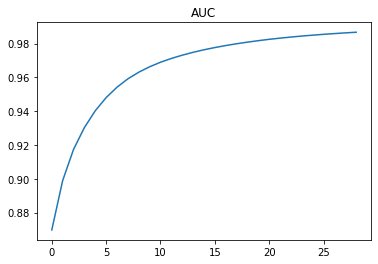

In [59]:
import matplotlib.pyplot as plt
plt.plot(np.array(m))
plt.title('AUC')

# PCA

In [39]:
from sklearn.decomposition import TruncatedSVD


clf = TruncatedSVD(100)
X_pca = clf.fit_transform(X)

In [40]:
def get_recommandation_pca(userID):
    n_users, n_items = X_pca.shape
    
    scores = model.predict(userID, np.arange(n_items))
    top_items = artist_names[np.argsort(-scores)]

    return top_items[0:10]#.unique()

In [47]:
get_recommandation_pca(2)

array(['Depeche Mode', 'Coldplay', 'Lady Gaga', 'Duran Duran', 'Madonna',
       'New Order', 'Marilyn Manson', 'Kylie Minogue', 'Daft Punk',
       'Goldfrapp'], dtype=object)

# AUC avec les Best parametres

In [62]:
model_Best = LightFM(k = 10, n = 10, learning_rate = 0.5, learning_schedule = 'adadelta', loss='warp',random_state=42)
m2 =[]
for i in range(1,30):
    model_Best.fit_partial(train, epochs=1)
    m2.append(auc_score(model_Best,train).mean())

Text(0.5, 1.0, 'AUC with Best parameters')

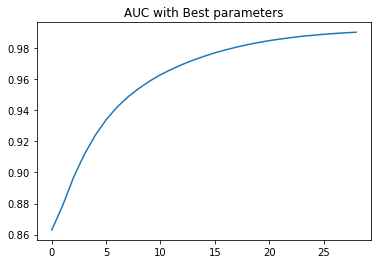

In [68]:
import matplotlib.pyplot as plt
plt.plot(np.array(m2))
plt.title('AUC with Best parameters')